# COMP24112 Summative Exercise: Air Quality Analysis (30 Marks)

This lab exercise is about air quality analysis, where you will predict air quality through solving classification and regression tasks. You will submit a notebook file, a pdf report, and a trained model. You will be marked for implementation, design, result and analysis. Your code should be easy to read and your report should be concise (max 600 words). It is strongly recommended that you use a LaTeX editor, such as [Overleaf](https://www.overleaf.com/), to write your report.

Please note your notebook should take no more than 10 minutes to run on lab computers. **There is 1 mark for code efficiency.**

## 1. Dataset and Knowledge Preparation

The provided dataset contains measurements of air quality from a multisensor device. The device used spectrometer analyzers (variables marked by "GT") and solid state metal oxide detectors (variables marked by "PT08.Sx"), as well as temperature (T), relative humidity (RH) and absolute humidity (AH) sensors. 

The dataset contains 3304 instances of hourly averaged measurements taken at road level in a polluted city. You will predict the CO(GT) variable representing carbon monoxide levels. There are missing features in this dataset, flagged by the number `-999`. 

You will need to pre-process the dataset to handle missing features, for which please self-learn from scikit-learn on how to [impute missing values](https://scikit-learn.org/stable/modules/impute.html). You will need to split the dataset into training and testing sets, also to run cross validation, when you see fit. For this, please self-learn from scikit-learn on [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).   

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()

# Import data - it should be saved in the same root directory as this notebook
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(5)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
720,1.4,986.50,6.085164,815.75,235.7,816.00,156.3,958.50,821.25,11.300,33.474999,0.447559
3164,1.4,989.75,7.971303,898.00,176.0,748.25,75.0,1442.00,1006.00,17.825,71.175001,1.439645
3039,0.7,919.50,3.589824,687.50,67.0,920.25,47.0,1317.00,820.25,20.475,62.050000,1.477094
1174,3.1,1444.25,13.144704,1088.50,214.0,844.00,143.0,1747.50,1623.75,14.650,48.625000,0.805969
903,5.7,1625.75,26.879758,1476.00,281.0,555.00,135.0,2355.75,1786.00,19.800,58.625000,1.339222


## 2. Linear Classification via Gradient Descent (13 marks)

The air quality is assessed using the CO(GT) variable. If it is no greater than 4.5, the air quality is good (CO(GT)<=4.5), otherwise, it is bad  (CO(GT)>4.5). You will perform binary classification to predict whether the air quality is good based on the other 11 varivables, i.e., from PT08.S1(CO) to AH. 

### 2.1 Model Training and Testing (4 marks)

This practice is about training a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation, and then testing its performance. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is 
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

Recall from your lectures that gradient descent is an iterative optimisation algorithm typically used in model training. Complete the implmentation of the training function `linear_gd_train` below, which trains your linear model by minimising the above provided training objective function $O$ using gradient descent.

The function should return the trained model weights and the corresponding objective function value (referred to as cost) per iteration. In addition to the training data, the function should take the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A default setting of these parameters has been provided below, which is able to provide reasonably good performance.  

**Note that scikit-learn is not allowed for implementation in this section.** We recommend that you avoid using `for` loops in your implementation of the objective function or weight update, and instead use built-in numpy operations for efficiency. 

In [2]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.01, random_state=42
          ):
    """
    A summary of your function goes here.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent
    random_state: random seed for reproducibility

    Returns an array of cost and model weights per iteration.
    """
    # Set random seed for reproducibility if using random initialisation of weights (optional)
    rng = np.random.default_rng(seed=random_state)

    # Create design matrix and labels
    #add a column of ones to the data to account for the bias term
    ones = np.ones((data.shape[0], 1))
    X_tilde = np.concatenate((ones, data), axis=1)
    y = np.where(labels, 1, -1)

    # Weight initialisation: use e.g. rng.standard_normal() or all zeros
    w = rng.standard_normal(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((n_iters, w.shape[0]))
    cost_all = np.zeros(n_iters)
    accuracy_all = np.zeros(n_iters)

    
    # GD update of weights
    for i in range(int(n_iters)):
        # calculate cost using the above formula
        y_pred = X_tilde @ w.T
        hinge_loss = np.maximum(0, 1 - y * y_pred)
        hinge_loss_sum = np.sum(hinge_loss)
        reg = 0.5 * np.dot(w[1], w[1])
        cost = c * hinge_loss_sum  + reg
        
        # weight update
        grad_hinge =  - np.where(hinge_loss > 0, y, 0)
        grad_reg = np.concatenate(([0], w[1:]))
        gradient = c * np.dot(grad_hinge, X_tilde) + grad_reg
        w -= learning_rate * gradient
        
        # calculate accuracy
        y_pred = np.where(y_pred > 0, 1, -1)
        accuracy = np.sum(y_pred == y) / len(y)
        
        
        # save w and cost of each iteration in w_all and cost_all
        w_all[i] = w
        cost_all[i] = cost
        accuracy_all[i] = accuracy

    # Return model parameters.
    return cost_all, w_all, accuracy_all


def linear_predict(data, w):
    """
    A summary of your function goes here.

    data: test data
    w: model weights

    Returns the predicted labels.
    """
    # Add a column of ones to the data to account for the bias term
    ones = np.ones((data.shape[0], 1))
    X_tilde = np.concatenate((ones, data), axis=1)

    # Calculate the predicted labels
    return X_tilde @ w>0

Now, you are ready to conduct a complete experiment of air quality classification. The provided code below splits the data into training and testing sets and imputes the missing features. 

In [3]:
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

In [4]:
print('Number of True',np.sum(binary_targets))
print('Number of False', np.sum(~binary_targets))

Number of True 224
Number of False 3080


In [5]:
def calculate_f1(y_true, y_pred):
    # Calculate true positives
    print(y_true.shape, y_pred.shape)
    tp = np.sum((y_true == y_pred) & (y_pred == True))
    fp = np.sum((y_true != y_pred) & (y_pred == True))
    fn = np.sum((y_true != y_pred) & (y_pred == False))
    tn = np.sum(( y_true == y_pred)& (y_pred == False))
    
    
    print(tp, fp, fn, tn)

    # Calculate precision and recall
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return f1

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

Write your code below, which should train the model, plot the training objective function value and the classification accuracy of the training set over iterations, and print the classification accuracy and $F_1$ score of the testing set. Note, use the default setting provided for $C$, $\eta$ and $N_{max}$. Your plot should have axis labels and titles.

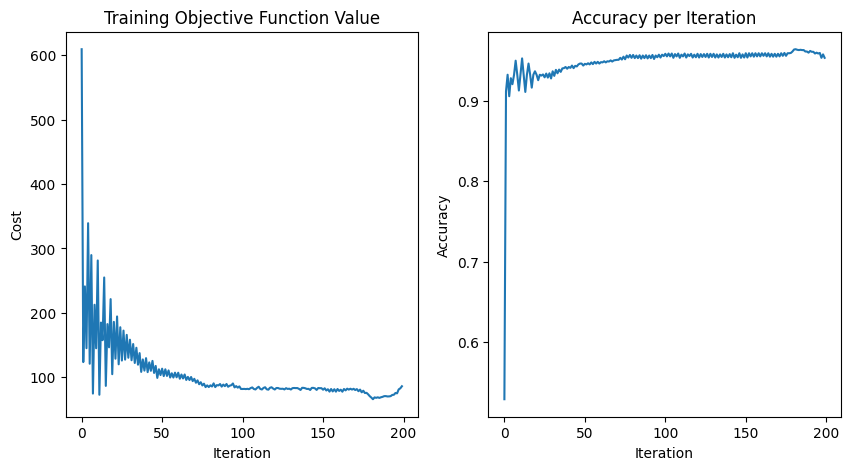

(2808,) (2808,)
71 2 119 2616
Test Accuracy: 0.9569088319088319
Test F1 Score: 0.5399239543726235
Cost 86.09022555979486
(496,) (496,)
8 0 26 462
Test Accuracy: 0.9475806451612904
Test F1 Score: 0.38095238095238093


In [6]:
# Train the model
cost_all, w_all, accuracy_all = linear_gd_train(train_X_cls, train_y_cls, c=0.2, n_iters=200, learning_rate=0.01, random_state=0)

# Plot accuracy and cost per iteration on training set
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cost_all)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Training Objective Function Value')

plt.subplot(1, 2, 2)
plt.plot(accuracy_all)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy per Iteration')
plt.savefig('fig2.1.png', dpi=400)
plt.show()

train_y_pred = linear_predict(train_X_cls, w_all[-1])
train_accuracy = accuracy(train_y_cls, train_y_pred)
train_f1_score = calculate_f1(train_y_cls, train_y_pred)

print("Test Accuracy:", train_accuracy)
print("Test F1 Score:", train_f1_score)
print("Cost", cost_all[-1])

# Apply imputation to the test set
test_X_cls = imputer.fit_transform(test_X_cls)
test_X_cls = scaler.fit_transform(test_X_cls)

# Predict on test set, report accuracy and f1 score
test_y_pred = linear_predict(test_X_cls, w_all[-1])
test_accuracy = accuracy(test_y_cls, test_y_pred)
test_f1_score = calculate_f1(test_y_cls, test_y_pred)

print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1_score)

### 2.2 Learning Rate Analysis (3 marks)

The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. Design an appropriate experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

Learning rate: 10, Test Accuracy: 0.6171652422, Test F1 Score: 0.38095238095238093
Learning rate: 1, Test Accuracy: 0.8799857550, Test F1 Score: 0.38095238095238093
Learning rate: 0.1, Test Accuracy: 0.9319800570, Test F1 Score: 0.38095238095238093
Learning rate: 0.01, Test Accuracy: 0.9579772080, Test F1 Score: 0.38095238095238093
Learning rate: 0.001, Test Accuracy: 0.9697293447, Test F1 Score: 0.38095238095238093
Learning rate: 0.0001, Test Accuracy: 0.9480056980, Test F1 Score: 0.38095238095238093
Learning rate: 1e-05, Test Accuracy: 0.5908119658, Test F1 Score: 0.38095238095238093
Learning rate: 1e-06, Test Accuracy: 0.4344729345, Test F1 Score: 0.38095238095238093


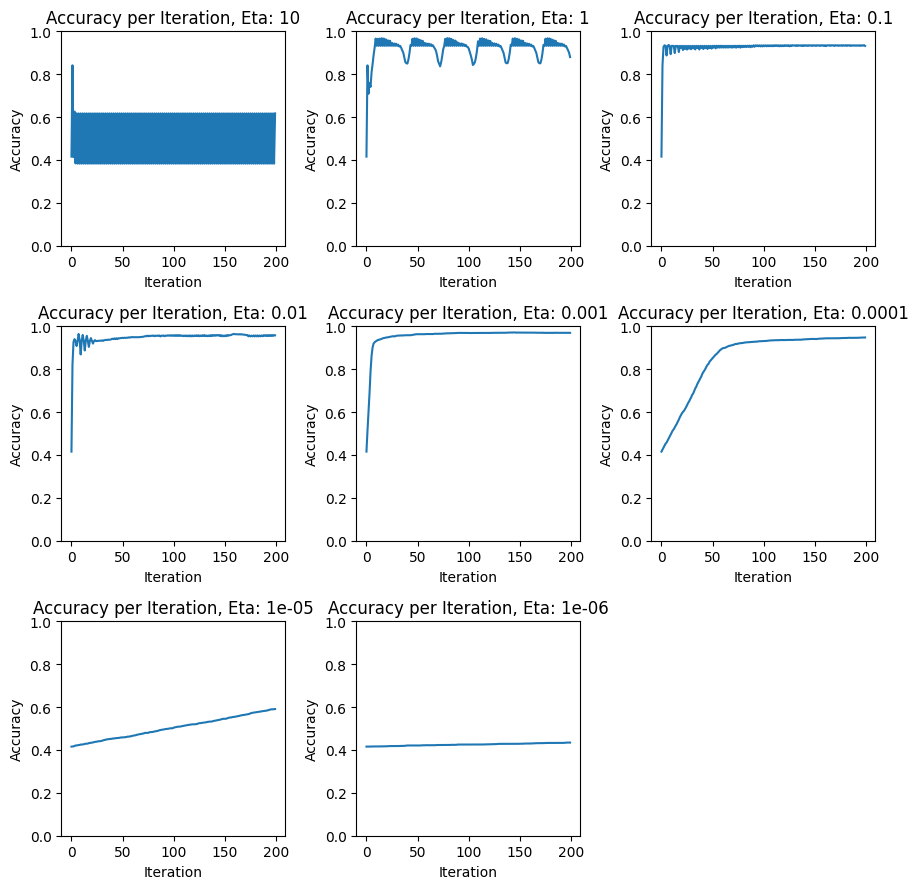

In [7]:
# Your code here
eta_all = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 1e-06]

fig = plt.figure(figsize=(9,9))

for i, eta in enumerate(eta_all):
    cost_all, w_all, accuracy_all = linear_gd_train(train_X_cls, train_y_cls, learning_rate=eta)
    ax = fig.add_subplot(3, 3, i+1)  # Add a subplot in the i-th position
    ax.plot(accuracy_all)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy per Iteration, Eta: {eta}')
    ax.set_ylim([0,1])

    test_y_pred = linear_predict(test_X_cls, w_all[-1])
    test_accuracy = accuracy_all[-1]
    print(f"Learning rate: {eta}, Test Accuracy: {test_accuracy:.10f}, Test F1 Score: {test_f1_score}")


plt.tight_layout()
plt.savefig("fig2.png", dpi=400)

### 2.3 Report (6 Marks)
Answer the following questions in your report, to be submitted separately:
1. Derive step-by-step the gradient of the provided training objective function $O$, and the updating equation of your model weights based on gradient descent. (3 marks)

2. What does the figure from section 2.1 tell you, and what is the indication of the classification accuracies of your training and testing sets? (1 mark)

3. Comment on the effect of $\eta$ on model training, and on the model performance during testing, based on your results observed in Section 2.2. (2 marks)

## 3. Air Quality Analysis by Neural Network (10 marks)

In this experiment, you will predict the CO(GT) value based on the other 11 variables through regression. You will use a neural network to build a nonlinear regression model. Familiarise yourself with how to build a regression model by mutlilayer perceptron (MLP) using the scikit learn tutorial (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression). 


### 3.1 Simple MLP Model Selection (4 marks)

This section is focused on the practical aspects of MLP implementation and model selection. We will first compare some model architectures. 

The set of MLP architectures to select is specified in `param_grid` below, including two MLPs with one hidden layer, where one has a small number of 3 hidden neurons, while the other has a larger number of 100 hidden neurons, and two MLPs with two hidden layers, where one is small (3, 3) and the other is larger (100, 100). It also includes two activation function options, i.e., the logistic and the rectified linear unit ("relu").  These result in a total of 8 model options, where sklearn default parameters are used for all the MLPs and their training. 

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {   
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

Your code below should do the following: Split the dataset into the training and testing sets. Preprocess the data by imputing the missing features. Use the training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. You can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation of the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.  


In [9]:
# Redo split for regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, sensor_data_full['CO(GT)'], test_size=0.15)

# Prepare the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)
test_X_cls = imputer.transform(test_X_cls)
test_X_cls = scaler.fit_transform(test_X_cls)

# Define MLP model
clf = MLPRegressor(param_grid)

# Initialise and fit the grid search
grid_search = GridSearchCV(clf, param_grid)

# Report the best parameters and the CV results
grid_search.fit(train_X_cls, train_y_cls)

best_params = grid_search.best_params_
best_config = grid_search.best_estimator_
cv_results = grid_search.cv_results_

print("Best parameters found: ", best_params)

print("CVResults:")
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print("Mean Score:", mean_score)
    print("Standard Deviation", std_score)
    print("Parameters:", params)

# Report model performance

C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Best parameters found:  {'activation': 'relu', 'hidden_layer_sizes': (100,)}
CVResults:
Mean Score: 0.8855993167976972
Standard Deviation 0.02182001847939307
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (3,)}
Mean Score: 0.9092999020019068
Standard Deviation 0.014734929821787748
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
Mean Score: 0.8865184391593358
Standard Deviation 0.020101227427737612
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (3, 3)}
Mean Score: 0.9091115312207785
Standard Deviation 0.013734557973126357
Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100)}
Mean Score: 0.7765016466604532
Standard Deviation 0.03534014950127449
Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (3,)}
Mean Score: 0.8982597588734565
Standard Deviation 0.010423555681199164
Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (100,)}
Mean Score: 0.6842975690906618
Standard Deviation 0.09639701907223377
Parameters: {'activa

In [10]:
best_model = MLPRegressor(**best_params)
best_model.fit(train_X_cls, train_y_cls)

test_pred = best_model.predict(test_X_cls)
mse = (np.square(test_pred - test_y_cls)).mean()
ssr = np.sum(np.square(test_pred - test_y_cls))
sst = np.sum(np.square(test_pred - np.mean(test_y_cls)))
r2 = 1 - ssr / sst

# print(test_pred, test_y_cls)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 0.20908798302075712
R2 Score: 0.8768944918468935


### 3.2 Training Algorithm Comparison: SGD and ADAM (2 Marks)

In this exercise, you will compare two training algorithms, stochastic gradient descent (SGD) and ADAM optimisation, for training an MLP with two hidden layers each containing 100 neurons with "relu" activation, under the settings specified in `test_params` as below.

In [11]:
test_params = [
    {
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'solver': 'adam',
        'max_iter': 300,
        'n_iter_no_change': 200
    },{
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'learning_rate': 'adaptive', 
        'momentum': 0.95, 
        'solver': 'sgd',
        'max_iter': 300,
        'n_iter_no_change': 200
    },
]

Write the code below, where each training algorithm should run for 300 iterations (make sure to set `early_stopping=False`). For both algorithms, (1) plot the training loss (use the defaul loss setting in sklearn), as well as the MSE of both training and testing sets, over iterations; and (2) print the MSE and $R^2$ score of the trained model using the testing set. 

C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


SGD MSE: 0.12501006106950022 
 SGD R2: 0.9335110854021407
Adam MSE: 0.13353278701560511 
 Adam R2: 0.933450182033942


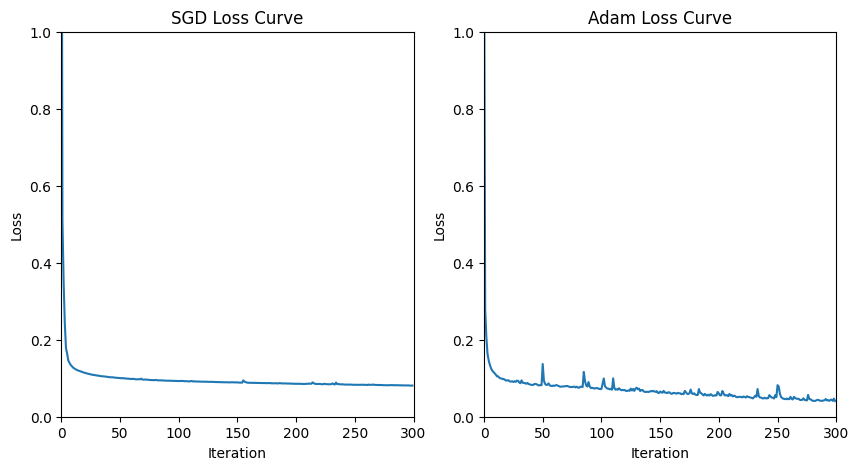

In [12]:
# Redo split for regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, sensor_data_full['CO(GT)'], test_size=0.15)

# Prepare the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)
test_X_cls = imputer.transform(test_X_cls)
test_X_cls = scaler.fit_transform(test_X_cls)

def r2_score(y_true, y_pred):
    ssr = np.sum(np.square(y_pred - y_true))
    sst = np.sum(np.square(y_pred - np.mean(y_true)))
    return 1 - ssr / sst

# Train models and plot learning curves
mlp_sgd = MLPRegressor(**test_params[1])
mlp_adam = MLPRegressor(**test_params[0])

mlp_sgd.fit(train_X_cls, train_y_cls)
mlp_adam.fit(train_X_cls, train_y_cls)

sgd_pred = mlp_sgd.predict(test_X_cls)
adam_pred = mlp_adam.predict(test_X_cls)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(mlp_sgd.loss_curve_, label='SGD')
plt.ylim(0, 1)
plt.xlim(0, 300)
plt.title('SGD Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(mlp_adam.loss_curve_, label='Adam')
plt.ylim(0, 1)
plt.xlim(0, 300)
plt.title('Adam Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.savefig('Fig3.jpg', dpi=400)

sgd_mse = (np.square(sgd_pred - test_y_cls)).mean()
adam_mse = (np.square(adam_pred - test_y_cls)).mean()

sgd_r2 = r2_score(test_y_cls, sgd_pred)
adam_r2 = r2_score(test_y_cls, adam_pred)

print("SGD MSE:", sgd_mse, '\n', "SGD R2:", sgd_r2)
print("Adam MSE:", adam_mse, '\n', "Adam R2:", adam_r2)


# Print final test set performance for both models


### 3.3 Report (4 Marks)
Answer the following questions in your report, to be submitted separately:
1. What conclusions can you draw based on your model selection results in Section 3.1? (2 marks)

2. Comment on the two training algorithms based on your results obtained in Section 3.2. (2 marks)

## 4.  Build A Robust MLP Regressor (6 Marks)

In this last experiment, you will develop and submit a robust MLP regressor to predict the CO(GT) value based on the other 11 variables, using the provided dataset. This robust regressor should account for the presence of missing and noisy features. 

Once you have developed your model, save it to a file using the provided `save_model` function for submission.

### 4.1 Model Development (3 Marks)

What you consider in model development should include (but not limited to) (1) handling of missing features in the unseen testing data, (2) handling of noisy features in the unseen testing data, and (3) a model selection practice.

Write your model development code below. Describe briefly in your report what you have considered in your model development.


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [14]:
# Your code here
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

train_X_cls, test_X_cls, train_y_cls, test_y_cls = train_test_split(sensor_data, sensor_data_full['CO(GT)'], test_size=0.15)

imputers = [
    ('KNNImputer4', KNNImputer(missing_values=-999, n_neighbors=4)),
    ('SimpleImputer_Mean', SimpleImputer(missing_values=-999, strategy='mean')),
    ('SimpleImputer_Median', SimpleImputer(missing_values=-999, strategy='median')),
]

mlp_params = {
        'activation': 'relu', 
        'alpha': 0.001, 
        'solver': 'adam',
        'learning_rate': 'adaptive',
    }

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer()),  # Placeholder
    ('scaler', RobustScaler()),
    ('mlp', MLPRegressor(**mlp_params))
])

# Define the grid of parameters to search over
param_grid = {
    'imputer': [imputer for name, imputer in imputers],
    'scaler': [StandardScaler(), RobustScaler()],
    'mlp__hidden_layer_sizes': [(50,50), (25,25)],
    'mlp__activation': ['relu', 'logistic',]
}

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(train_X_cls, train_y_cls)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Predict with the best model
adam_pred = grid_search.predict(test_X_cls)

# Print the MSE of the best model
print("Best model MSE: ", mean_squared_error(test_y_cls, adam_pred))

#Best parameters found:  
#{'imputer': SimpleImputer(missing_values=-999, strategy='median'), 'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (50, 50), 'scaler': StandardScaler()}

pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=-999, strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(activation='relu', hidden_layer_sizes=(50, 50)))
])

# Define the grid of parameters to search over
param_grid = {
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0] 
}

# Set up the grid search
grid_search_cheap = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

grid_search_cheap.fit(train_X_cls, train_y_cls)

# Print the best parameters
print("Best parameters: ", grid_search_cheap.best_params_)

# Predict with the best model
pred = grid_search_cheap.predict(test_X_cls)

# Print the MSE of the best model
print("Best model MSE: ", mean_squared_error(test_y_cls, pred))
#Best parameters:  {'mlp__alpha': 0.1}

print('big')

cv_res = grid_search.cv_results_
for mean, std, params in zip(cv_res['mean_test_score'],cv_res['std_test_score'], cv_res['params']):
    print("Mean Score:", mean)
    print("Standard Deviation", std)
    print("Parameters:", params)

print('small')

cheap_cv_res = grid_search_cheap.cv_results_
for mean, std, params in zip(cheap_cv_res['mean_test_score'],cheap_cv_res['std_test_score'], cheap_cv_res['params']):
    print("Mean Score:", mean)
    print("Standard Deviation", std)
    print("Parameters:", params)

C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Best parameters:  {'imputer': SimpleImputer(missing_values=-999, strategy='median'), 'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (25, 25), 'scaler': StandardScaler()}
Best model MSE:  0.1584567431512248


C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chizh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Best parameters:  {'mlp__alpha': 0.0001}
Best model MSE:  0.15457311567191853
big
Mean Score: -0.201066944224573
Standard Deviation 0.0379631717199531
Parameters: {'imputer': KNNImputer(missing_values=-999, n_neighbors=4), 'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (50, 50), 'scaler': StandardScaler()}
Mean Score: -0.18940776667905812
Standard Deviation 0.02863975904790735
Parameters: {'imputer': KNNImputer(missing_values=-999, n_neighbors=4), 'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (50, 50), 'scaler': RobustScaler()}
Mean Score: -0.20254842029373177
Standard Deviation 0.03716097780039587
Parameters: {'imputer': KNNImputer(missing_values=-999, n_neighbors=4), 'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (25, 25), 'scaler': StandardScaler()}
Mean Score: -0.20228830326577515
Standard Deviation 0.03700934271088621
Parameters: {'imputer': KNNImputer(missing_values=-999, n_neighbors=4), 'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (25, 25), 'scaler

In [18]:
train_X_cls, test_X_cls, train_y_cls, test_y_cls = train_test_split(sensor_data, sensor_data_full['CO(GT)'], test_size=0.15)

pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=-999, strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(activation='relu', hidden_layer_sizes=(100,100)))
])

pipeline.fit(train_X_cls, train_y_cls)
pred = pipeline.predict(test_X_cls)

r2 = r2_score(test_y_cls, pred)
print(f'R-squared: {r2}')

rmse = np.sqrt(mean_squared_error(test_y_cls, pred))
print(f'RMSE: {rmse}')

R-squared: 0.9419071549138187
RMSE: 0.33812261998876125


## Result
Result is good since the rmse is 4% of the tested range and r2 score is 90.5%!

## 4.2 External Testing (3 Marks)
Save your trained model for submission, and submit it along with your notebook and report. It will be run and evaluated on a test set unseen by you.

**Important: set your university username (e.g. mbxxabc3) below when saving your model.** Failure to do this correctly would lead to your model not being marked!

In [15]:
import model_eval_utils

#### SAVE YOUR MODEL
student_username = "j36003zc" # SET YOUR USERNAME HERE
model = pipeline
model_eval_utils.save_model(student_username, model)

NameError: name 'pipeline' is not defined

In [16]:
print(f"Total notebook run time: {time.time() - notebook_start_time:.0f} seconds")

Total notebook run time: 445 seconds


### Option to test your saved model
Use the `run_model()` function to make sure your saved model can be loaded and run before submitting.

Please note the score returned by `run_model()` is not in any way indicative of your final mark. This is just a simple test to make sure your model can be loaded and run. When testing your model, the GTA will run your model following the practice below, but replacing the bunk_data with the testing data.

In [16]:
# some bunk data
bunk_data = np.array([[ 1.22400000e+03,  9.97440117e+00,
        9.76666667e+02,  2.50600000e+02,  5.71333333e+02,
        1.30700000e+02,  1.42433333e+03,  1.00166667e+03,
        2.32666664e+01,  3.57999992e+01,  1.00855762e+00],
    [ 9.24250000e+02,   3.97337806e+00,
        7.09250000e+02,  6.30000000e+01,  1.15800000e+03,
        7.50000000e+01,  1.31800000e+03,  6.09750000e+02,
        1.60500000e+01,  4.13500004e+01,  7.48680717e-01],
    [ 8.92000000e+02,  5.06611560e+00,
        7.66750000e+02,  7.10000000e+01,  1.18000000e+03,
        8.40000000e+01,  1.46600000e+03,  6.56750000e+02,
        1.79749999e+01,  5.14499998e+01,  1.05039283e+00]])
bunk_labels = np.array([2. , 1.3, 6.1])

score = model_eval_utils.run_model(student_username, 
                                test_data=bunk_data, 
                                test_labels=bunk_labels, 
                                model_folder=".")

Attempting to load from ....
Loaded .\j36003zc.sav model.
Model score: -1.056282238873028
